<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/Part_2_03_custom_normalization_maxnormdense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
# Step 1: Load Dataset (Boston Housing Regression)
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [3]:
# Step 2: Normalize Inputs
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train_scaled = (x_train - mean) / std
x_test_scaled = (x_test - mean) / std

In [4]:
# Step 3: Define Custom Normalization Dense Layer
class MaxNormDense(keras.layers.Layer):
    def __init__(self, units, max_norm=3.0, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.max_norm = max_norm

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True
        )
        self.bias = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        # Normalize the weights by L2 norm
        norms = tf.norm(self.kernel, axis=0, keepdims=True)
        desired = tf.clip_by_value(norms, clip_value_min=0.0, clip_value_max=self.max_norm)
        self.kernel.assign(self.kernel * self.max_norm / (1e-7 + norms))
        return tf.matmul(inputs, self.kernel) + self.bias

In [5]:
# Step 4: Build Model with Custom Layer
model = keras.Sequential([
    MaxNormDense(64, max_norm=2.5, input_shape=(13,)),
    layers.ReLU(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

<ipython-input-4-9d6feb2c8d2b>:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Step 5: TensorBoard Setup
tensorboard_logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=tensorboard_logdir, histogram_freq=1)

In [7]:
# Step 6: Train the Model
history = model.fit(
    x_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tensorboard_cb]
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 486.2165 - mae: 20.4995 - val_loss: 447.3457 - val_mae: 19.3007
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 358.9971 - mae: 16.8489 - val_loss: 312.3842 - val_mae: 15.5986
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 221.7232 - mae: 12.6139 - val_loss: 208.7081 - val_mae: 12.2359
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 146.6292 - mae: 10.0592 - val_loss: 137.3667 - val_mae: 9.5536
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 123.1561 - mae: 8.8681 - val_loss: 98.0590 - val_mae: 7.9522
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 97.4209 - mae: 7.6348 - val_loss: 76.5052 - val_mae: 6.9194
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 75.2582 - mae: 6.6434 - val_loss: 62.8181 - val_mae: 6.1430
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 53.5528 - mae: 5.4605 - val_loss: 52.7366 - val_mae: 5.5120
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━

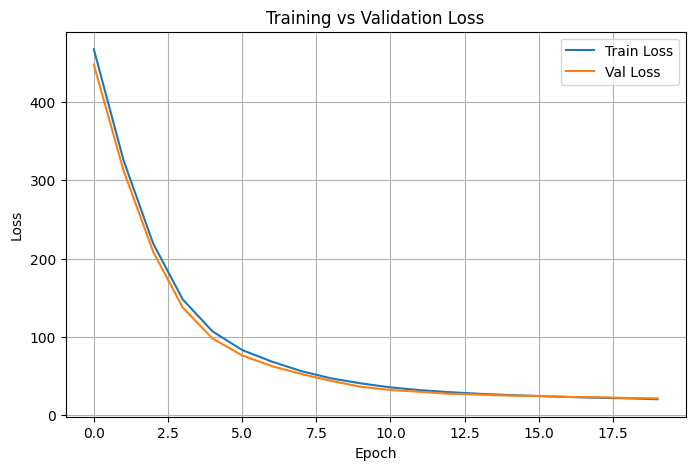

In [8]:
# Step 7: Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()